In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install transformers
!pip install datasets
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!nvidia-smi

Mon Sep 19 15:27:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import os
import gc
import math
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
from tqdm import tqdm
import re
import html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam, SGD, AdamW, RAdam
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import StratifiedKFold,StratifiedGroupKFold,GroupKFold
from sklearn.metrics import log_loss,f1_score

from transformers import AutoModel, AutoConfig, AutoTokenizer, AdamW, DataCollatorWithPadding
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
DIR = '/content/drive/MyDrive/Competitions/Signate/MUFJ'
INPUT_DIR = os.path.join(DIR,'input')
OUTPUT_DIR = os.path.join(DIR,'output')
OUTPUT_SUB_DIR = os.path.join(OUTPUT_DIR,'submission')
#OUTPUT_MODEL_DIR = os.path.join(OUTPUT_DIR,'model')
OUTPUT_MODEL_DIR19 = DIR + '/output/model/EXP19/'
OUTPUT_MODEL_DIR20 = DIR + '/output/model/EXP20/'
OUTPUT_MODEL_DIR22 = DIR + '/output/model/EXP22/'
OUTPUT_MODEL_DIR23 = DIR + '/output/model/EXP23/'
OUTPUT_MODEL_DIR24 = DIR + '/output/model/EXP24/'
OUTPUT_MODEL_DIR25 = DIR + '/output/model/EXP25/'
OUTPUT_MODEL_DIR27 = DIR + '/output/model/EXP27/'
OUTPUT_MODEL_DIR28 = DIR + '/output/model/EXP28/'
OUTPUT_MODEL_DIR31 = DIR + '/output/model/EXP31/'
OUTPUT_MODEL_DIR41 = DIR + '/output/model/EXP41/'
OUTPUT_MODEL_DIR42 = DIR + '/output/model/EXP42/'

In [6]:
class CFG19:
    num_workers=4
    path=OUTPUT_MODEL_DIR19
    config_path=path+'config.pth'
    model="microsoft/deberta-v3-base"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=True
    freezing=True
    clean_content = True

class CFG20:
    num_workers=4
    path=OUTPUT_MODEL_DIR20
    config_path=path+'config.pth'
    model="microsoft/deberta-v3-large"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=True
    freezing=True
    clean_content = True

class CFG22:
    num_workers=4
    path=OUTPUT_MODEL_DIR22
    config_path=path+'config.pth'
    model="facebook/bart-large"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=128
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=False
    freezing=False
    clean_content = True

class CFG23:
    num_workers=4
    path=OUTPUT_MODEL_DIR23
    config_path=path+'config.pth'
    model="microsoft/deberta-large"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=True
    freezing=True
    clean_content = True

class CFG24:
    num_workers=4
    path=OUTPUT_MODEL_DIR24
    config_path=path+'config.pth'
    model="funnel-transformer/large"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=False
    freezing=False
    clean_content = True

class CFG25:
    num_workers=4
    path=OUTPUT_MODEL_DIR25
    config_path=path+'config.pth'
    model="xlnet-large-cased"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=128
    seed=42
    n_fold=4
    trn_fold=[1, 2, 3]
    gradient_checkpointing=False
    freezing=False
    clean_content = True

class CFG27:
    num_workers=4
    path=OUTPUT_MODEL_DIR27
    config_path=path+'config.pth'
    model="microsoft/deberta-xlarge"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=True
    freezing=True
    clean_content = True

class CFG28:
    num_workers=4
    path=OUTPUT_MODEL_DIR28
    config_path=path+'config.pth'
    model="microsoft/deberta-base"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=True
    freezing=True
    clean_content = True

class CFG31:
    num_workers=4
    path=OUTPUT_MODEL_DIR31
    config_path=path+'config.pth'
    model="funnel-transformer/medium"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=False
    freezing=False
    clean_content = True

class CFG41:
    num_workers=4
    path=OUTPUT_MODEL_DIR41
    config_path=path+'config.pth'
    model="facebook/bart-base"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=False
    freezing=False
    clean_content = True

class CFG42:
    num_workers=4
    path=OUTPUT_MODEL_DIR42
    config_path=path+'config.pth'
    model="facebook/bart-large-mnli"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=180
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=False
    freezing=False
    clean_content = True

In [7]:
def get_score(labels, outputs):
    thresh = 0.5
    y_pred = outputs
    y_true = labels
    return f1_score(y_true, (y_pred>thresh).astype(int))


def get_logger(filename=OUTPUT_DIR+'/infrence'):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=CFG25.seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=CFG25.seed)

In [8]:
def freeze(module):
    """
    Freezes module's parameters.
    """
    
    for parameter in module.parameters():
        parameter.requires_grad = False
        
def get_freezed_parameters(module):
    """
    Returns names of freezed parameters of the given module.
    """
    
    freezed_parameters = []
    for name, parameter in module.named_parameters():
        if not parameter.requires_grad:
            freezed_parameters.append(name)
            
    return freezed_parameters

def set_embedding_parameters_bits(embeddings_path, optim_bits=32):
    """
    https://github.com/huggingface/transformers/issues/14819#issuecomment-1003427930
    """
    
    embedding_types = ("word", "position", "token_type")
    for embedding_type in embedding_types:
        attr_name = f"{embedding_type}_embeddings"
        
        if hasattr(embeddings_path, attr_name): 
            bnb.optim.GlobalOptimManager.get_instance().register_module_override(
                getattr(embeddings_path, attr_name), 'weight', {'optim_bits': optim_bits}
            )

In [9]:
oof_19 = pd.read_pickle(CFG19.path+'oof_df.pkl')
oof_20 = pd.read_pickle(CFG20.path+'oof_df.pkl')
oof_22 = pd.read_pickle(CFG22.path+'oof_df.pkl')
oof_23 = pd.read_pickle(CFG23.path+'oof_df.pkl')
oof_24 = pd.read_pickle(CFG24.path+'oof_df.pkl')
oof_25 = pd.read_pickle(CFG25.path+'oof_df.pkl')
oof_27 = pd.read_pickle(CFG27.path+'oof_df.pkl')
oof_28 = pd.read_pickle(CFG28.path+'oof_df.pkl')
oof_31 = pd.read_pickle(CFG31.path+'oof_df.pkl')
oof_41 = pd.read_pickle(CFG41.path+'oof_df.pkl')
oof_42 = pd.read_pickle(CFG42.path+'oof_df.pkl')

In [10]:
labels = oof_25['state'].values

preds_19 = oof_19['pred'].values
preds_20 = oof_20['pred'].values
preds_22 = oof_22['pred'].values
preds_23 = oof_23['pred'].values
preds_24 = oof_24['pred'].values
preds_25 = oof_25['pred'].values
preds_27 = oof_27['pred'].values
preds_28 = oof_28['pred'].values
preds_31 = oof_31['pred'].values
preds_41 = oof_41['pred'].values
preds_42 = oof_42['pred'].values

preds1 = (preds_25+preds_28) / 2
preds2 = (preds_19+preds_22+preds_31+preds_41) / 4 #0.822
preds3 = (preds_23+preds_24+preds1+preds_42) / 4  #0.8202
preds4 = (preds_20+preds_27) / 2   #0.8213
preds = (preds2+preds3+preds4)/3  #0.8261

score = get_score(labels, preds)
LOGGER.info(f'CV Score: {score:<.4f}')

CV Score: 0.8261
INFO:__main__:CV Score: 0.8261


In [11]:
test = pd.read_csv(os.path.join(INPUT_DIR,'test.csv'))
sub = pd.read_csv(os.path.join(INPUT_DIR,'sample_submit.csv'),header=None)
sub.columns = ['id','state']

In [12]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub('',text)

def remove_html(text):
    html=re.compile(r"<[^>]*?>")
    return html.sub('',text)

def cleaning(texts):
    clean_texts = []
    for text in texts:
        # htmlタグを削除
        text = remove_URL(text)
        text = remove_html(text)
        #アルファベット以外をスペースに置き換え
        #clean_punc = re.sub(r'[^a-zA-Z]', ' ', text)
        #改行削除
        #text = text.replace("\n","")
        clean_texts.append(text)
    return clean_texts

def get_goal_values(df):
  df["goal"].replace("100000+","100000-100000",inplace=True)
  _df = df["goal"].str.split('-').apply(pd.Series).astype(float)
  _df.columns = ["goal_max","goal_min"]
  df["goal_max"] = _df["goal_max"].astype(str)
  df["goal_min"] = _df["goal_min"].astype(str)
  df["goal_median"] = _df[["goal_max","goal_min"]].median(axis=1)
  df["goal_median"] = df["goal_median"].astype(int)
  return df

if CFG25.clean_content==True:
    test['html_content'] = test['html_content'].map(lambda x: str(x))
    test['html_content'] = test['html_content'].apply(html.unescape)
    p = re.compile(r"<[^>]*?>|&amp;|[/'’\"”]")
    test['html_content'] = test['html_content'].map(lambda x: p.sub("", x))
    test['html_content'] = test['html_content'].map(lambda x: x.lstrip())
    test['html_content'] = test['html_content'].fillna('missing')

test = get_goal_values(test)
test['inputs'] = test.goal_median.astype(str) + ' [SEP] ' + test.duration.astype(str) + ' [SEP] ' + test.country + ' [SEP] ' + test.category1 + ' [SEP] ' + test.category2 + ' [SEP] ' + test.html_content

In [13]:
# ====================================================
# tokenizer
# ====================================================
CFG19.tokenizer = AutoTokenizer.from_pretrained(CFG19.path+'tokenizer/')
CFG20.tokenizer = AutoTokenizer.from_pretrained(CFG20.path+'tokenizer/')
CFG22.tokenizer = AutoTokenizer.from_pretrained(CFG22.path+'tokenizer/')
CFG23.tokenizer = AutoTokenizer.from_pretrained(CFG23.path+'tokenizer/')
CFG24.tokenizer = AutoTokenizer.from_pretrained(CFG24.path+'tokenizer/')
CFG25.tokenizer = AutoTokenizer.from_pretrained(CFG25.path+'tokenizer/')
CFG27.tokenizer = AutoTokenizer.from_pretrained(CFG27.path+'tokenizer/')
CFG28.tokenizer = AutoTokenizer.from_pretrained(CFG28.path+'tokenizer/')
CFG31.tokenizer = AutoTokenizer.from_pretrained(CFG31.path+'tokenizer/')
CFG41.tokenizer = AutoTokenizer.from_pretrained(CFG41.path+'tokenizer/')
CFG42.tokenizer = AutoTokenizer.from_pretrained(CFG42.path+'tokenizer/')

In [14]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False,
                           truncation=True)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TestDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.inputs = df['inputs'].values

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.inputs[item])
        return inputs

In [15]:
# ====================================================
# Model
# ====================================================
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

class MaxPooling(nn.Module):
    def __init__(self):
        super(MaxPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        embeddings = last_hidden_state.clone()
        embeddings[input_mask_expanded == 0] = -1e4
        max_embeddings, _ = torch.max(embeddings, dim=1)
        return max_embeddings
    

class CustomModel1(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
            LOGGER.info(self.config)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        if self.cfg.gradient_checkpointing:
            self.model.gradient_checkpointing_enable()

        # Freezing
        if cfg.freezing:
            # freezing embeddings and first 2 layers of encoder
            freeze((self.model).embeddings)
            freeze((self.model).encoder.layer[:2])
            cfg.after_freezed_parameters = filter(lambda parameter: parameter.requires_grad, (self.model).parameters())

        self.pool = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, cfg.target_size)
        self._init_weights(self.fc)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        feature = self.pool(last_hidden_states, inputs['attention_mask'])
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(feature)
        return output

class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

class MaxPooling(nn.Module):
    def __init__(self):
        super(MaxPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        embeddings = last_hidden_state.clone()
        embeddings[input_mask_expanded == 0] = -1e4
        max_embeddings, _ = torch.max(embeddings, dim=1)
        return max_embeddings
    

class CustomModel2(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
            LOGGER.info(self.config)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        if self.cfg.gradient_checkpointing:
            self.model.gradient_checkpointing_enable()

        # Freezing
        if cfg.freezing:
            # freezing embeddings and first 2 layers of encoder
            freeze((self.model).embeddings)
            freeze((self.model).encoder.layer[:2])
            cfg.after_freezed_parameters = filter(lambda parameter: parameter.requires_grad, (self.model).parameters())

        self.pool = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, cfg.target_size)
        #self._init_weights(self.fc)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        feature = self.pool(last_hidden_states, inputs['attention_mask'])
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(feature)
        return output

In [16]:
# ====================================================
# inference
# ====================================================
def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [17]:
test_dataset19 = TestDataset(CFG19, test)
test_loader19 = DataLoader(test_dataset19,
                         batch_size=CFG19.batch_size,
                         shuffle=False,
                         num_workers=CFG19.num_workers, pin_memory=True, drop_last=False)
predictions_19 = []
for fold in CFG19.trn_fold:
    model = CustomModel1(CFG19, config_path=CFG19.config_path, pretrained=False)
    state = torch.load(CFG19.path+f"{CFG19.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader19, model, device)
    predictions_19.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_19 = np.mean(predictions_19, axis=0)

100%|██████████| 307/307 [01:43<00:00,  2.98it/s]


In [18]:
test_dataset20 = TestDataset(CFG20, test)
test_loader20 = DataLoader(test_dataset20,
                         batch_size=CFG20.batch_size,
                         shuffle=False,
                         num_workers=CFG20.num_workers, pin_memory=True, drop_last=False)
predictions_20 = []
for fold in CFG20.trn_fold:
    model = CustomModel1(CFG20, config_path=CFG20.config_path, pretrained=False)
    state = torch.load(CFG20.path+f"{CFG20.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader20, model, device)
    predictions_20.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_20 = np.mean(predictions_20, axis=0)

100%|██████████| 307/307 [05:14<00:00,  1.03s/it]


In [19]:
test_dataset22 = TestDataset(CFG22, test)
test_loader22 = DataLoader(test_dataset22,
                         batch_size=CFG22.batch_size,
                         shuffle=False,
                         num_workers=CFG22.num_workers, pin_memory=True, drop_last=False)
predictions_22 = []
for fold in CFG22.trn_fold:
    model = CustomModel2(CFG22, config_path=CFG22.config_path, pretrained=False)
    state = torch.load(CFG22.path+f"{CFG22.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader22, model, device)
    predictions_22.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_22 = np.mean(predictions_22, axis=0)

100%|██████████| 307/307 [02:20<00:00,  2.18it/s]


In [20]:
test_dataset23 = TestDataset(CFG23, test)
test_loader23 = DataLoader(test_dataset23,
                         batch_size=CFG23.batch_size,
                         shuffle=False,
                         num_workers=CFG23.num_workers, pin_memory=True, drop_last=False)
predictions_23 = []
for fold in CFG23.trn_fold:
    model = CustomModel1(CFG23, config_path=CFG23.config_path, pretrained=False)
    state = torch.load(CFG23.path+f"{CFG23.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader23, model, device)
    predictions_23.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_23 = np.mean(predictions_23, axis=0)

100%|██████████| 307/307 [05:17<00:00,  1.03s/it]


In [21]:
test_dataset24 = TestDataset(CFG24, test)
test_loader24 = DataLoader(test_dataset24,
                         batch_size=CFG24.batch_size,
                         shuffle=False,
                         num_workers=CFG24.num_workers, pin_memory=True, drop_last=False)
predictions_24 = []
for fold in CFG24.trn_fold:
    model = CustomModel1(CFG24, config_path=CFG24.config_path, pretrained=False)
    state = torch.load(CFG24.path+f"{CFG24.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader24, model, device)
    predictions_24.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_24 = np.mean(predictions_24, axis=0)

100%|██████████| 307/307 [03:24<00:00,  1.50it/s]


In [22]:
test_dataset25 = TestDataset(CFG25, test)
test_loader25 = DataLoader(test_dataset25,
                         batch_size=CFG25.batch_size,
                         shuffle=False,
                         num_workers=CFG25.num_workers, pin_memory=True, drop_last=False)
predictions_25 = []
for fold in CFG25.trn_fold:
    model = CustomModel1(CFG25, config_path=CFG25.config_path, pretrained=False)
    state = torch.load(CFG25.path+f"{CFG25.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader25, model, device)
    predictions_25.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_25 = np.mean(predictions_25, axis=0)

100%|██████████| 307/307 [02:57<00:00,  1.73it/s]


In [23]:
test_dataset27 = TestDataset(CFG27, test)
test_loader27 = DataLoader(test_dataset27,
                         batch_size=CFG27.batch_size,
                         shuffle=False,
                         num_workers=CFG27.num_workers, pin_memory=True, drop_last=False)
predictions_27 = []
for fold in CFG27.trn_fold:
    model = CustomModel1(CFG27, config_path=CFG27.config_path, pretrained=False)
    state = torch.load(CFG27.path+f"{CFG27.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader27, model, device)
    predictions_27.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_27 = np.mean(predictions_27, axis=0)

100%|██████████| 307/307 [10:31<00:00,  2.06s/it]


In [24]:
test_dataset28 = TestDataset(CFG28, test)
test_loader28 = DataLoader(test_dataset28,
                         batch_size=CFG28.batch_size,
                         shuffle=False,
                         num_workers=CFG28.num_workers, pin_memory=True, drop_last=False)
predictions_28 = []
for fold in CFG28.trn_fold:
    model = CustomModel1(CFG28, config_path=CFG28.config_path, pretrained=False)
    state = torch.load(CFG28.path+f"{CFG28.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader28, model, device)
    predictions_28.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_28 = np.mean(predictions_28, axis=0)

100%|██████████| 307/307 [01:44<00:00,  2.94it/s]


In [ ]:
test_dataset31 = TestDataset(CFG31, test)
test_loader31 = DataLoader(test_dataset31,
                         batch_size=CFG31.batch_size,
                         shuffle=False,
                         num_workers=CFG31.num_workers, pin_memory=True, drop_last=False)
predictions_31 = []
for fold in CFG31.trn_fold:
    model = CustomModel1(CFG31, config_path=CFG31.config_path, pretrained=False)
    state = torch.load(CFG31.path+f"{CFG31.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader31, model, device)
    predictions_31.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_31 = np.mean(predictions_31, axis=0)

In [26]:
test_dataset41 = TestDataset(CFG41, test)
test_loader41 = DataLoader(test_dataset41,
                         batch_size=CFG41.batch_size,
                         shuffle=False,
                         num_workers=CFG41.num_workers, pin_memory=True, drop_last=False)
predictions_41 = []
for fold in CFG41.trn_fold:
    model = CustomModel2(CFG41, config_path=CFG41.config_path, pretrained=False)
    state = torch.load(CFG41.path+f"{CFG41.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader41, model, device)
    predictions_41.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_41 = np.mean(predictions_41, axis=0)

100%|██████████| 307/307 [01:29<00:00,  3.44it/s]


In [27]:
test_dataset42 = TestDataset(CFG42, test)
test_loader42 = DataLoader(test_dataset42,
                         batch_size=CFG42.batch_size,
                         shuffle=False,
                         num_workers=CFG42.num_workers, pin_memory=True, drop_last=False)
predictions_42 = []
for fold in CFG42.trn_fold:
    model = CustomModel2(CFG42, config_path=CFG42.config_path, pretrained=False)
    state = torch.load(CFG42.path+f"{CFG42.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader42, model, device)
    predictions_42.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_42 = np.mean(predictions_42, axis=0)

100%|██████████| 307/307 [03:20<00:00,  1.53it/s]


In [28]:
submit = sub.copy()
#submit.columns = ["id","label"]

predictions1 = (predictions_25+predictions_28) / 2
predictions2 = (predictions_19+predictions_22+predictions_31+predictions_41) / 4
predictions3 = (predictions_23+predictions_24+predictions_42+predictions1) / 4
predictions4 = (predictions_20+predictions_27) / 2
predictions = (predictions2+predictions3+predictions4) / 3


submit['label'] = predictions
submit['state'] = (predictions>0.5).astype(int)

submit[["id","state"]].to_csv(os.path.join(OUTPUT_SUB_DIR,"ensemble_normal_submission8261.csv"),index=False,header=False)
display(submit)

,id,state,label
0,test_00000,1,0.652910
1,test_00001,1,0.997854
2,test_00002,1,0.979318
3,test_00003,0,0.054806
4,test_00004,0,0.014872
...,...,...,...
9795,test_09795,1,0.657859
9796,test_09796,1,0.997365
9797,test_09797,0,0.220432
9798,test_09798,1,0.821811


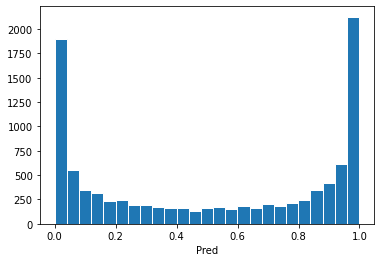

In [29]:
plt.hist(submit.label,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

In [30]:
#train,testでダブっているデータを参照
dup_test_ids = ['test_01704','test_03707','test_04353','test_04453','test_04645','test_06909','test_08232']
sub_dup= submit[submit["id"].isin(dup_test_ids)]  

In [31]:
T = pd.DataFrame([['train_00365','train_01463','train_02156','train_04506','train_06891','train_08302','train_09470'],
                [0,1,1,1,1,1,0],
                ['test_08232','test_01704','test_06909','test_04453','test_03707','test_04353','test_04645']]).T
T.columns =["train id","true label","id"]
T = T.sort_values(by="id")
T = T.merge(sub_dup,how='left',on='id')
T

,train id,true label,id,state,label
0,train_01463,1,test_01704,1,0.994916
1,train_06891,1,test_03707,1,0.994637
2,train_08302,1,test_04353,1,0.930243
3,train_04506,1,test_04453,1,0.997915
4,train_09470,0,test_04645,0,0.352525
5,train_02156,1,test_06909,1,0.751388
6,train_00365,0,test_08232,0,0.187061
